## Regression Analysis on Best Model

In [1]:
"""
@author: Dwyer
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import os
import numpy as np
from optuna_train import *
debug_mode = True  # faster experiments for debugging

In [2]:
#Prepare the DataFrame that will be used downstream
dp = DataPreparer()
dp.createPCAs()
dp.sparsePCAs()
df = dp.getDataframe()

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)

In [3]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode
exprExec.setModelFactory(PCDNNV2ModelFactory())

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


2022-07-27 23:20:08.905776: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 23:20:09.298823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14142 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [52]:
import model_analyzer.model_analysis as model_analysis
import importlib; importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
emb_and_regressor = bestModel = bestModel.get_layer('emb_and_regression_model')
print(experimentSettings.keys())
dm = experimentSettings['data_manager']
#dm.createTrainTestData(experimentSettings['dataSetMethod'], experimentSettings['noOfCpv'], experimentSettings['ipscaler'], experimentSettings['opscaler'])

print(f'\nexperimentSettings: {str(experimentSettings)[:300]}...')
print(f'\nbestModel.input_shape: {bestModel.input_shape}')

dict_keys(['dataSetMethod', 'ipscaler', 'opscaler', 'noOfCpv', 'ZmixPresent', 'concatenateZmix', 'kernel_constraint', 'kernel_regularizer', 'activity_regularizer', 'input_data_cols', 'data_manager', 'val_losses', 'model_R2', 'history'])

experimentSettings: {'dataSetMethod': 'AllSpecies_randomequaltraintestsplit_AllDependants', 'ipscaler': None, 'opscaler': 'StandardScaler', 'noOfCpv': 9, 'ZmixPresent': 'Y', 'concatenateZmix': 'Y', 'kernel_constraint': 'Y', 'kernel_regularizer': 'Y', 'activity_regularizer': 'N', 'input_data_cols': ['YiH', 'YiO2', 'YiO'...

bestModel.input_shape: [(None, 67), (None, 1)]
len testing df:  1452
input names: ['input_1']
output names (before pruning): ['dynamic_source_prediction', 'static_source_prediction']
['zmix', 'cpv1', 'cpv2', 'cpv3', 'cpv4', 'cpv5', 'cpv6', 'cpv7', 'cpv8', 'cpv9']


[(None, 67), (None, 1)]
{'static_source_prediction': (None, 8), 'dynamic_source_prediction': (None, 9)}


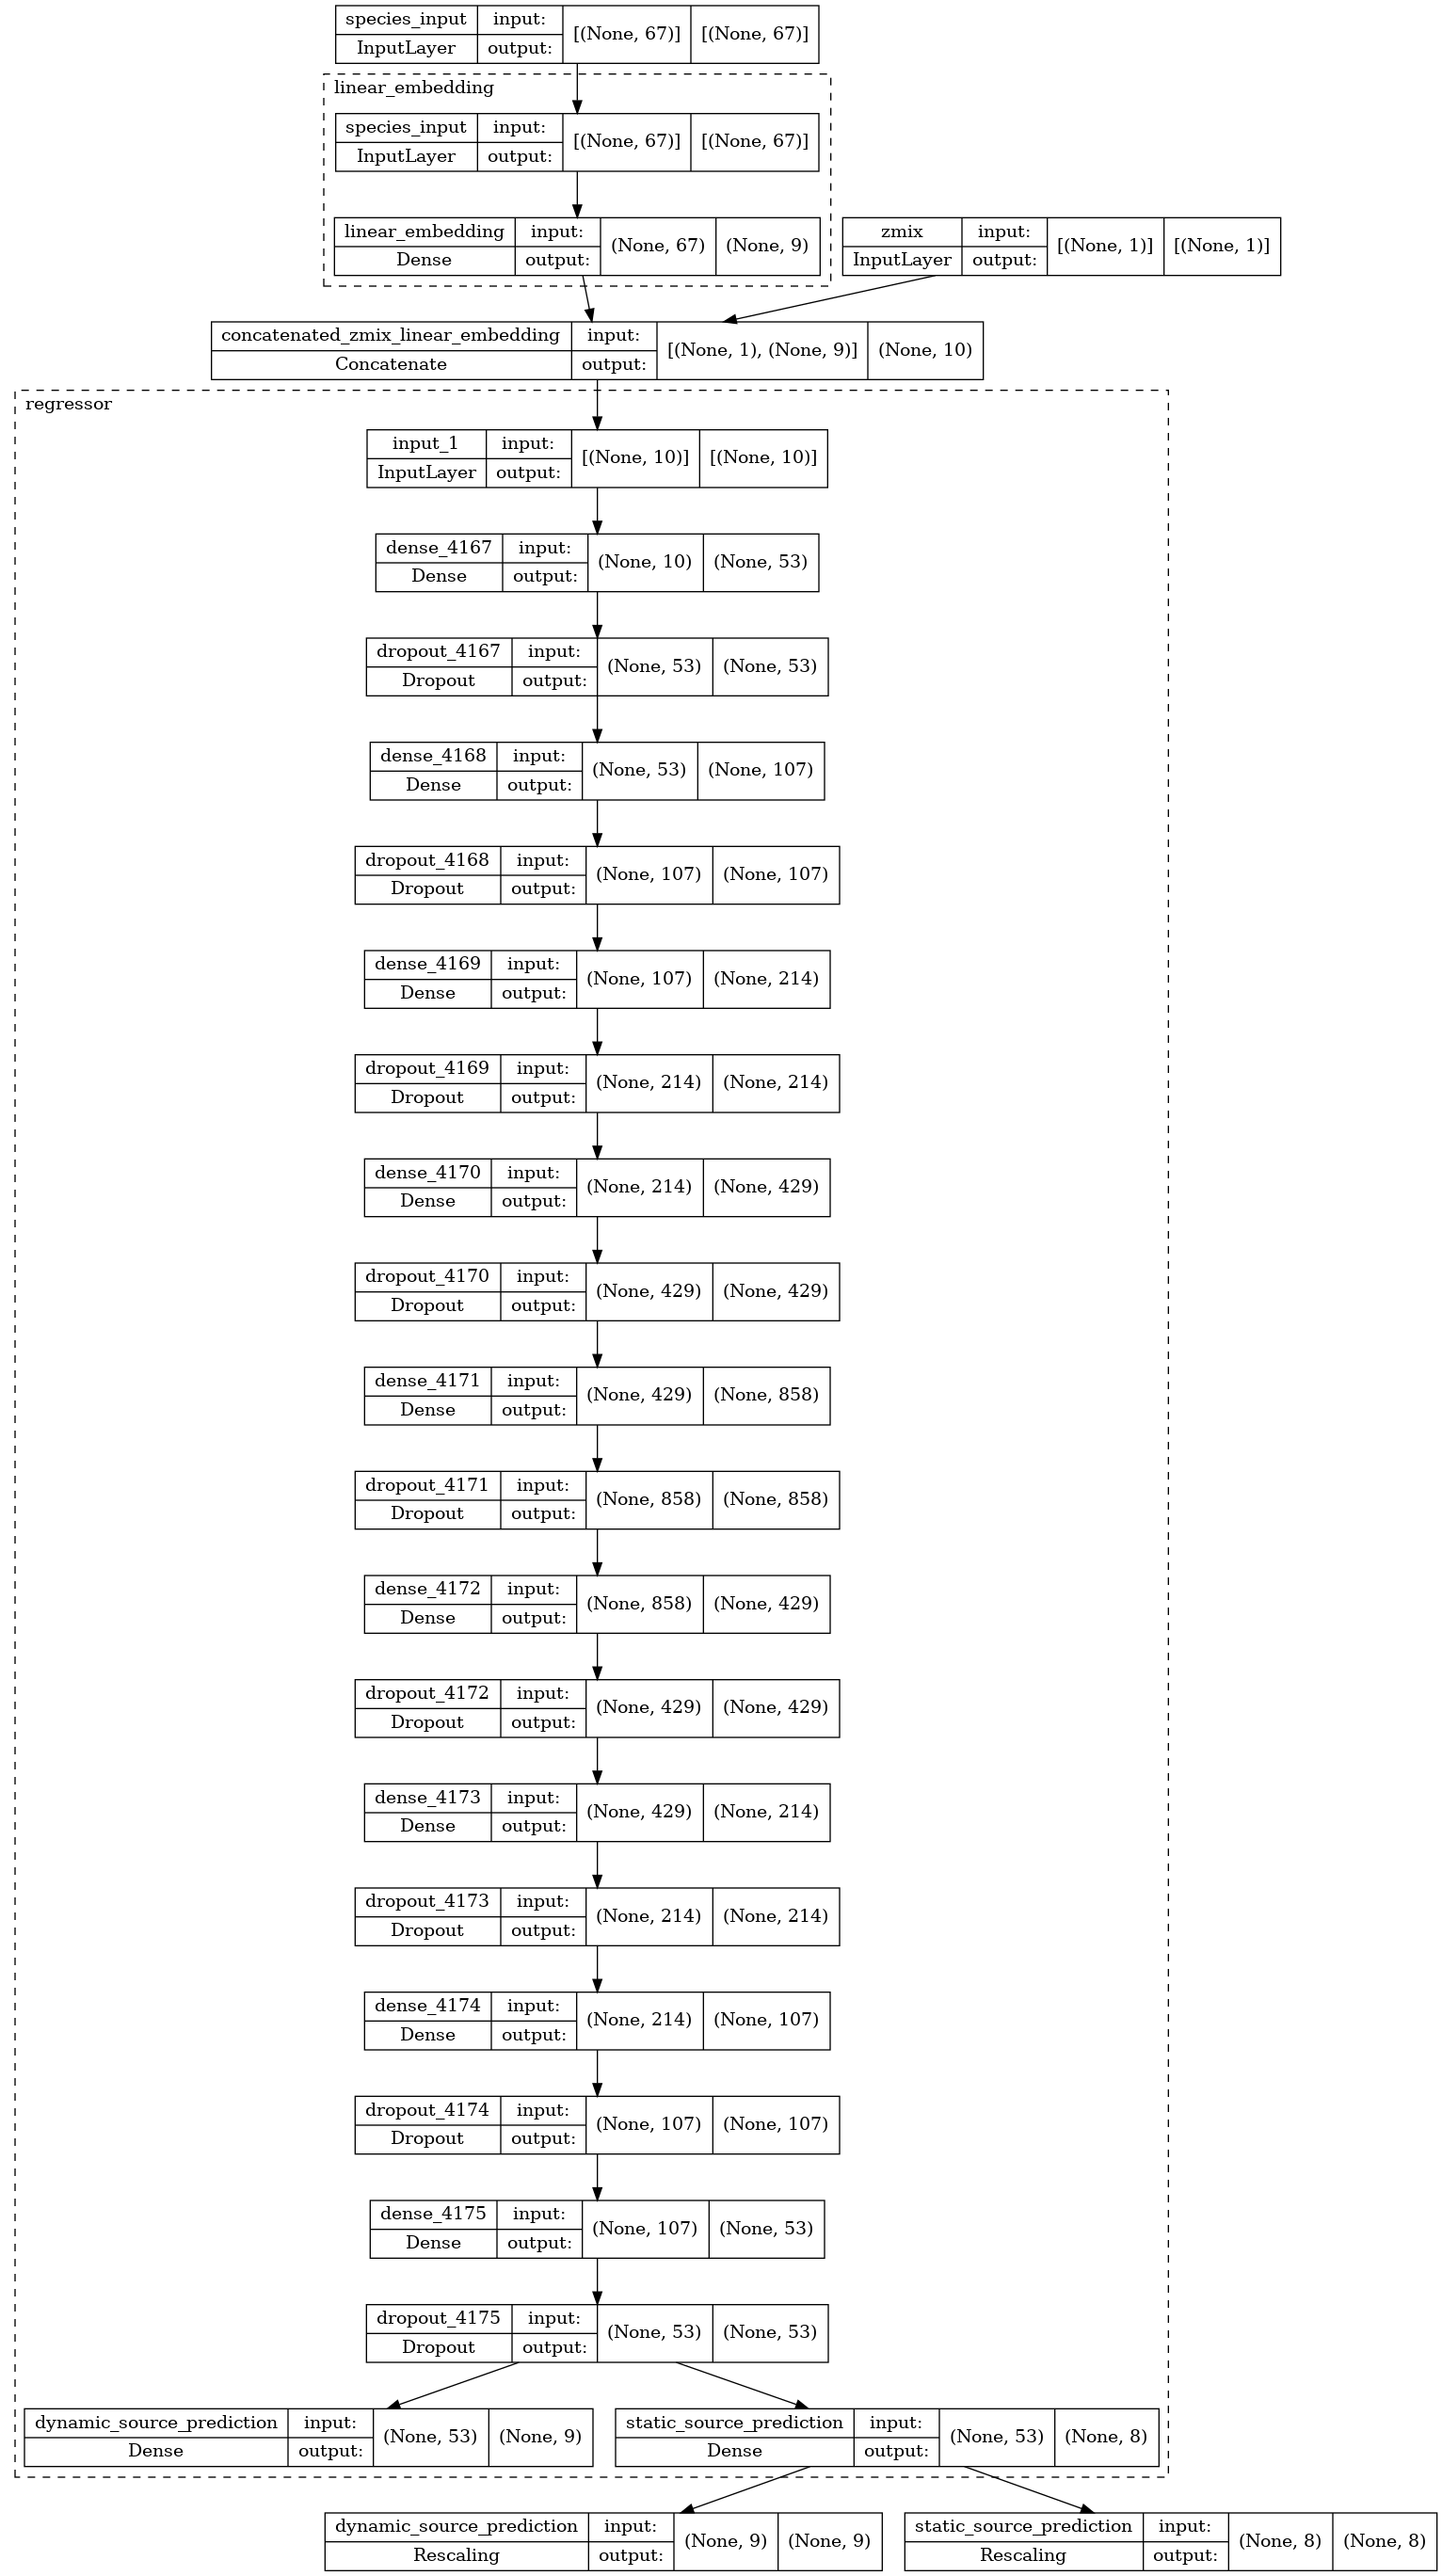

In [116]:
# simpler than reconstructing, but sanity is good...
linear_embedder = bestModel.get_layer('linear_embedding')
regressor = bestModel.get_layer('regressor')

print(bestModel.input_shape)
print(bestModel.output_shape)
tf.keras.utils.plot_model(bestModel, expand_nested=True, show_shapes=True)

## Manually Construct Data & Prepare Model:

In [128]:
X_train, X_test, Y_train, Y_test, zmix_train, zmix_test = dm.getTrainTestData()
source_train, source_test = dm.getSourceTrainTestData()

CPV_train = linear_embedder({"species_input": np.asarray(X_train)})
true_dyn_train = linear_embedder({"species_input": np.asarray(source_train)})
true_dyn_test = linear_embedder({"species_input": np.asarray(source_test)})

In [129]:
input_dict_train = {"species_input": X_train, 'zmix': zmix_train}
input_dict_test = {"species_input": X_test, 'zmix': zmix_test}
output_dict_train = {'static_source_prediction': Y_train, 'dynamic_source_prediction': true_dyn_train}
output_dict_test = {'static_source_prediction': Y_test, 'dynamic_source_prediction': true_dyn_test}

In [140]:
from models import pcdnnv2_model_factory

@tf.function
def R2(yt,yp): return tf.reduce_mean(1-tf.reduce_mean((yp-yt)**2, axis=0)/tf.math.reduce_variance(yt,axis=0))

# for metric definitions see get_metric_dict()
metrics={'static_source_prediction': R2, 'dynamic_source_prediction': R2}
emb_and_regressor.compile(loss=None, optimizer='adam', metrics=metrics)

# Best Model Evaluation:
## R^2 Eval -- 
(**NOTE: requires max batch size or you get erroneous results!**)

In [141]:
# Verified to make "raw evaluation" (7/27/22) (as long as batch size is entire dataset!)
eval_ = emb_and_regressor.evaluate(input_dict_train, output_dict_train, batch_size=X_train.shape[0], return_dict=True, verbose=False)

print(f'Total loss: {eval_["loss"]}')
print(f'CPV_source_prediction R^2: {eval_["dynamic_source_prediction_R2"]}')
print(f'Species_source_prediction R^2: {eval_["static_source_prediction_R2"]}')
print(f'Average R^2: {(eval_["dynamic_source_prediction_R2"]+eval_["static_source_prediction_R2"])/2}')

Total loss: 0.033310551196336746
CPV_source_prediction R^2: 0.9634219408035278
Species_source_prediction R^2: 0.9574518203735352
Average R^2: 0.9604368805885315


## QQ regression plots:

mae 0.045651070749732785


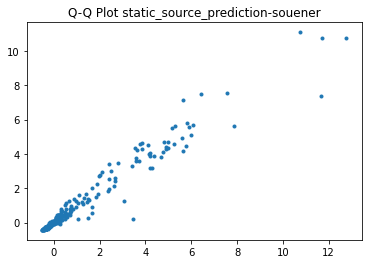

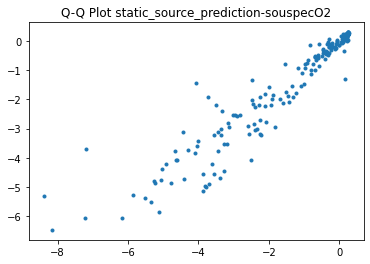

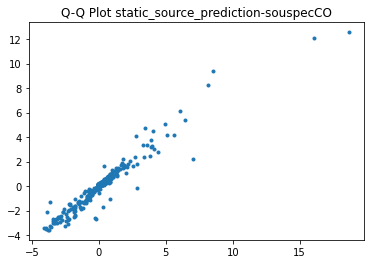

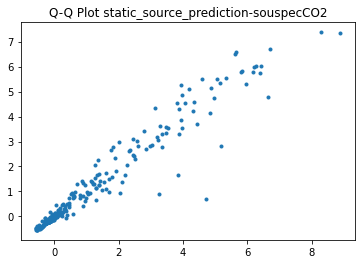

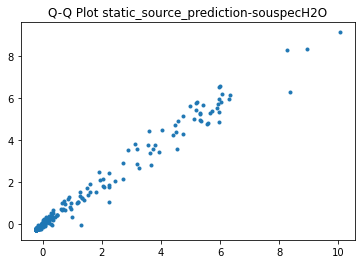

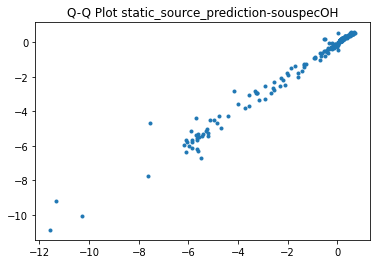

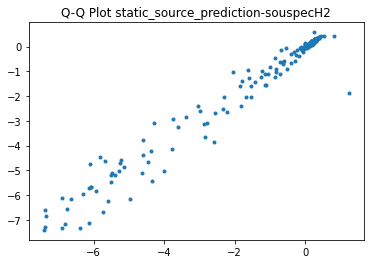

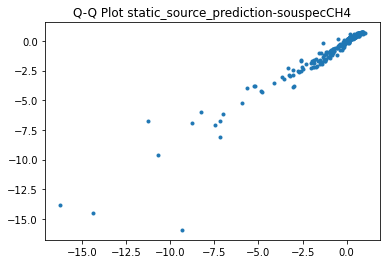

mae 0.0326103


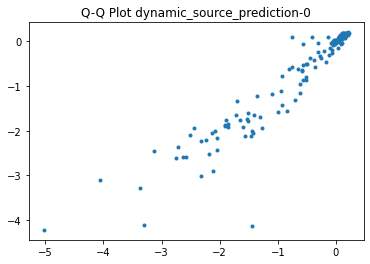

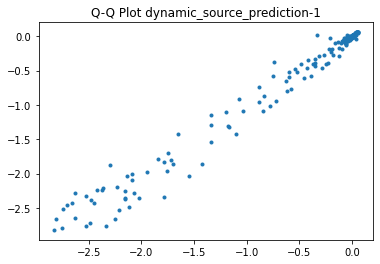

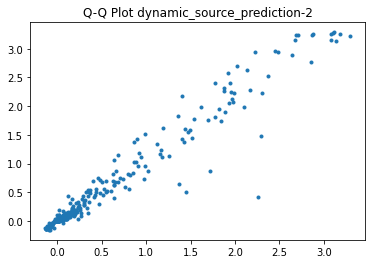

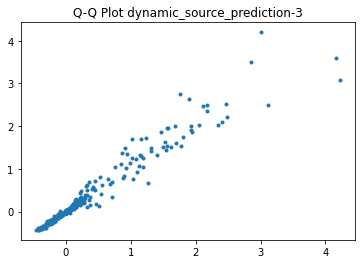

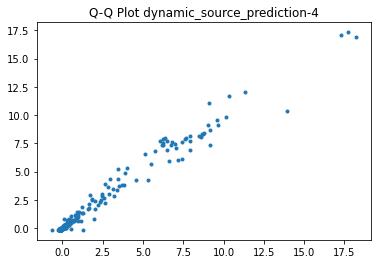

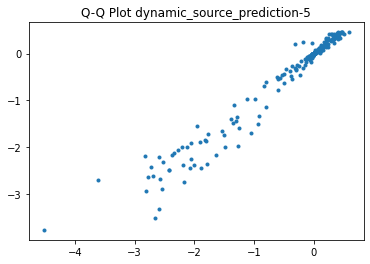

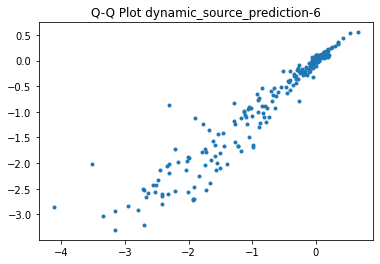

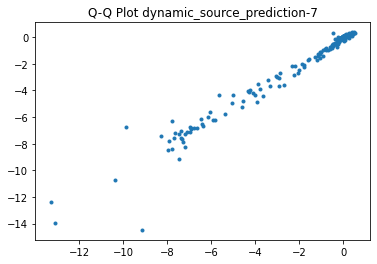

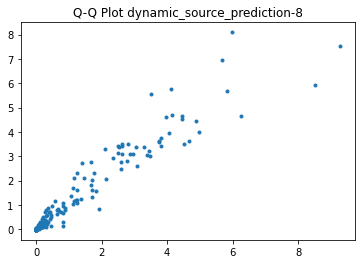

In [142]:
# QQ plots are good!!
all_dependants = ["souener", "souspecO2", "souspecCO", "souspecCO2", "souspecH2O", "souspecOH", "souspecH2", "souspecCH4"]
def make_Error_plots(input_dict, output_dict, name, plot_residuals=False, names=None):
    preds = emb_and_regressor.predict(input_dict)
    if names is None: names = list(range(preds[name].shape[1]))
    
    residuals = output_dict[name]-preds[name]
    print('mae', np.mean(np.abs(residuals)))
    
    Y_vals = residuals if plot_residuals else preds[name]
    plt_name = 'Residual' if plot_residuals else 'Q-Q'
    for i in range(preds[name].shape[1]):
        plt.figure(i)
        plt.plot(output_dict[name][:, i], Y_vals[:,i], '.')
        plt.title(f'{plt_name} Plot {name}-{names[i]}')
        plt.show()
make_Error_plots(input_dict_test, output_dict_test, 'static_source_prediction', names=all_dependants, plot_residuals=False)
make_Error_plots(input_dict_test, output_dict_test, 'dynamic_source_prediction', plot_residuals=False)

## Residual Regression Plots:

mae 0.045651070749732785


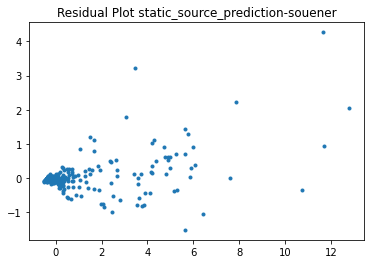

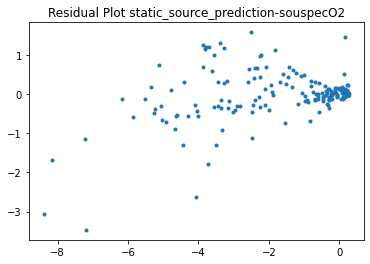

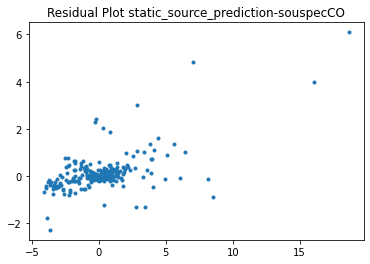

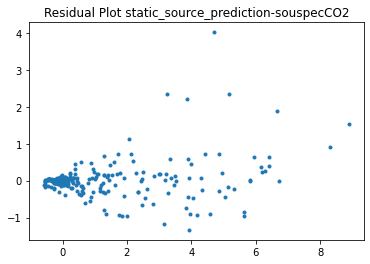

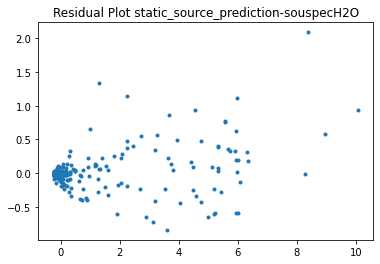

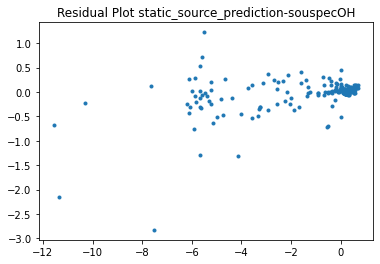

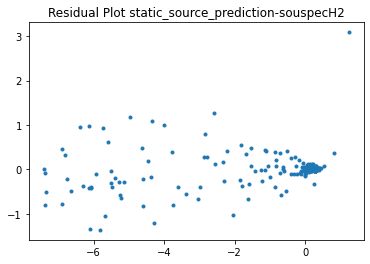

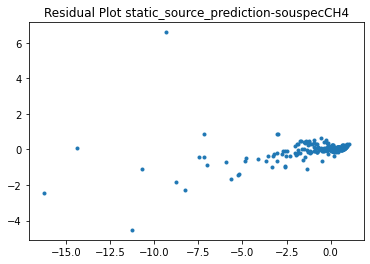

mae 0.0326103


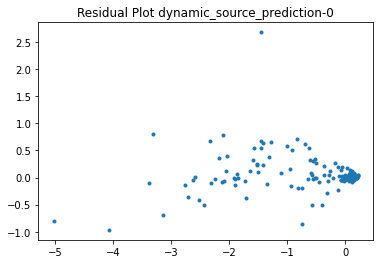

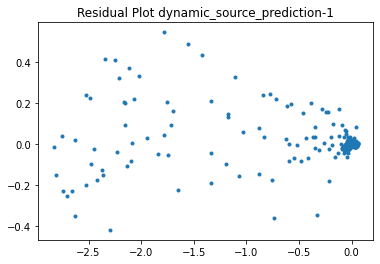

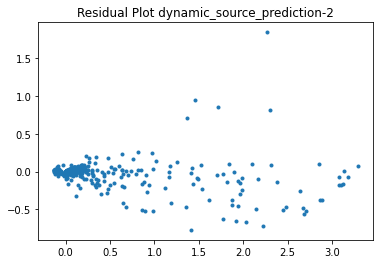

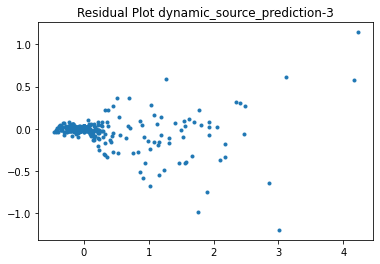

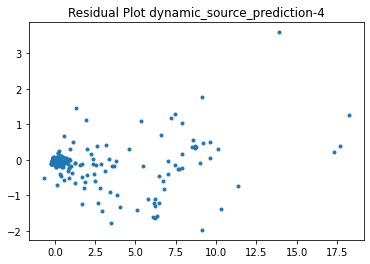

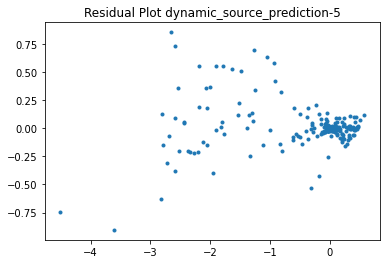

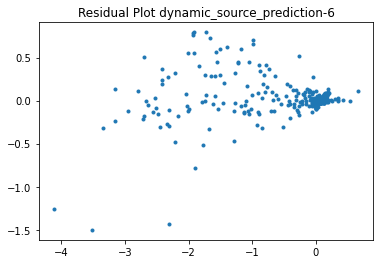

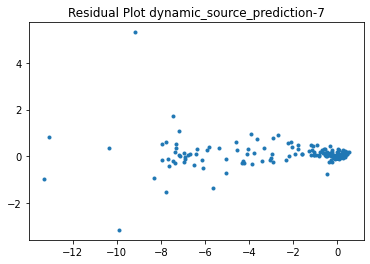

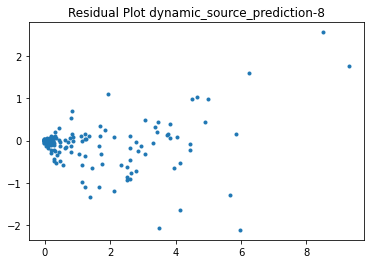

In [143]:
make_Error_plots(input_dict_test, output_dict_test, 'static_source_prediction', names=all_dependants, plot_residuals=True)
make_Error_plots(input_dict_test, output_dict_test, 'dynamic_source_prediction', plot_residuals=True)

### CPV Distribution Plots (its Weird!):

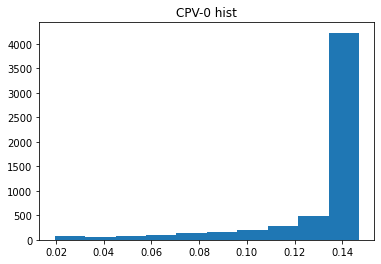

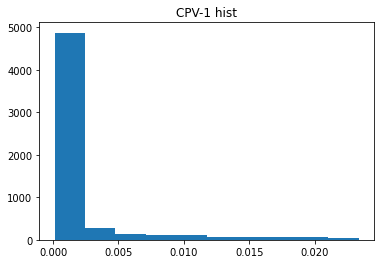

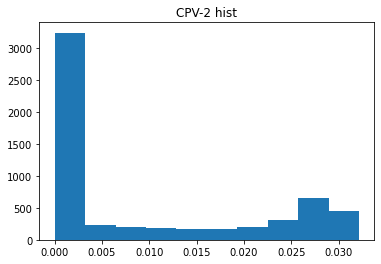

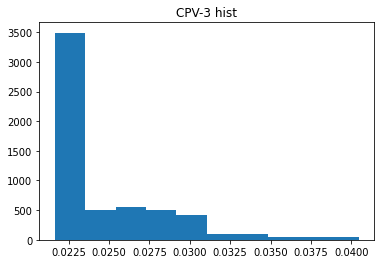

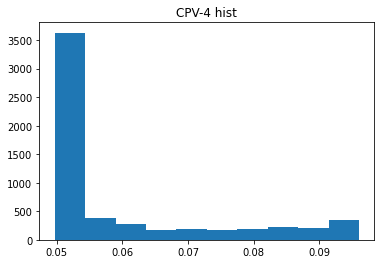

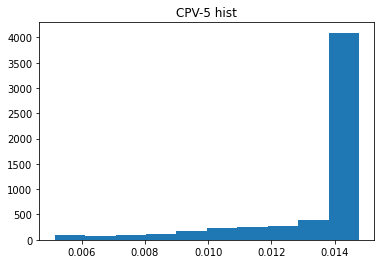

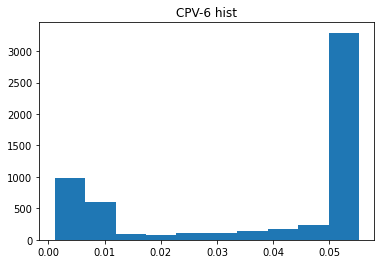

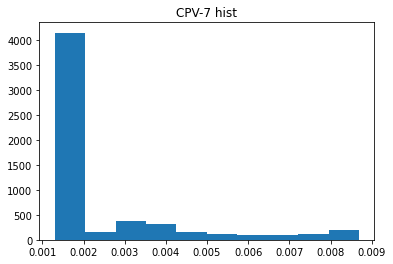

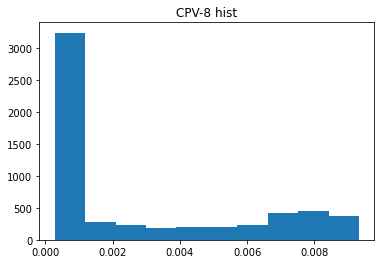

In [144]:
for i in range(CPV_train.shape[1]):
    plt.figure(i)
    plt.hist(CPV_train[:,i].numpy().squeeze())
    plt.title(f'CPV-{i} hist')
    plt.show()

In [115]:
# Sanity check on names!
def sanity_check_names(): # function to prevent namespace pollution
    input_dict_train, input_dict_test, output_dict_train, output_dict_test = exprExec.prepare_model_data_dicts(dm=dm)
    X_train_cols = dm.df_testing[dm.input_data_cols].columns
    source_train_cols = source_train.columns

    # check that order of source-terms matches order of species
    assert all(np.array([col[2:] for col in X_train_cols]) == np.array([col[7:] for col in source_train_cols]))
sanity_check_names()